In [1]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from formulae import design_matrices

sns.set()

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

In [3]:
games = pd.read_parquet(Path("../data/iowa_games.parquet"))

In [4]:
games.describe()

,id,season,week,attendance,venue_id,home_id,home_points,home_post_win_prob,home_pregame_elo,home_postgame_elo,away_id,away_points,away_post_win_prob,away_pregame_elo,away_postgame_elo,excitement_index
count,8.100000e+01,81.000000,81.000000,72.000000,81.000000,81.000000,76.000000,76.000000,80.000000,75.000000,81.000000,76.000000,76.000000,79.000000,74.000000,76.000000
mean,4.012164e+08,2020.012346,7.604938,59169.805556,3672.641975,1488.641975,22.736842,0.611103,1705.225000,1718.453333,1412.802469,19.157895,0.388897,1666.417722,1669.202703,4.699521
std,1.995202e+05,2.052400,4.088640,24701.039025,826.382059,1047.931228,12.328145,0.398205,167.338282,179.566166,1086.824128,13.455163,0.398205,200.159463,210.021785,2.362943
min,4.009345e+08,2017.000000,1.000000,771.000000,347.000000,66.000000,0.000000,0.000813,1243.000000,1125.000000,36.000000,0.000000,0.000007,1208.000000,1208.000000,0.369269
25%,4.010129e+08,2018.000000,4.000000,57027.500000,3793.000000,194.000000,14.000000,0.134487,1627.750000,1633.000000,164.000000,10.000000,0.014320,1507.000000,1495.250000,2.879791
50%,4.012473e+08,2020.000000,8.000000,66838.000000,3793.000000,2294.000000,23.000000,0.789722,1704.000000,1709.000000,2294.000000,17.000000,0.210278,1670.000000,1674.000000,4.289374
75%,4.014051e+08,2022.000000,11.000000,69250.000000,3830.000000,2294.000000,30.250000,0.985680,1810.000000,1840.500000,2294.000000,24.000000,0.865513,1829.000000,1831.750000,6.775234
max,4.015204e+08,2023.000000,15.000000,111519.000000,6577.000000,2509.000000,55.000000,0.999993,2165.000000,2233.000000,2751.000000,63.000000,0.999187,2161.000000,2065.000000,9.477399


In [5]:
def get_iowa_points(game):
    if game.away_team == "Iowa":
        return game.away_points
    else:
        return game.home_points


iowa_points = games.apply(get_iowa_points, axis="columns").dropna()
games["Iowa_points"] = iowa_points
games["Home_game"] = games["home_team"] == "Iowa"
games["Years_since_2017"] = games["season"] - 2017

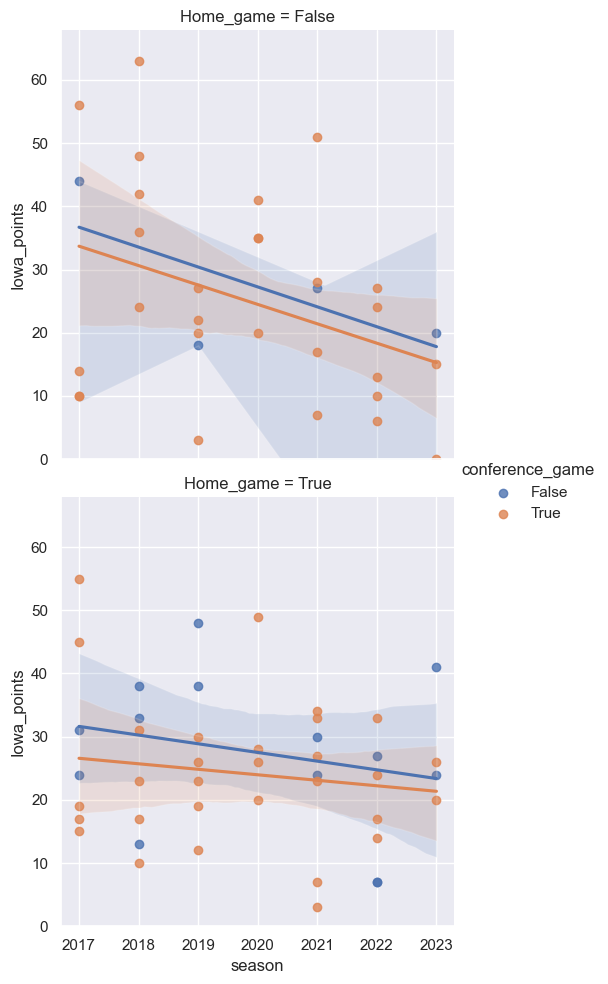

In [6]:
g = sns.lmplot(
    games,
    x="season",
    y="Iowa_points",
    hue="conference_game",
    row="Home_game",
)
g.set(ylim=(0, None))

In [7]:
games.pivot_table(
    "Iowa_points",
    "conference_game",
    "Home_game",
)

Home_game,False,True
conference_game,,
False,27.250000,27.5
True,25.142857,24.2


# Bayesian mixed-effects model

Let's predict scoring from 2019 on...

Let's modify [this pymc tutorial](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-poisson-regression.html) for the analysis.


In [8]:
design_matrix = design_matrices(
    "Iowa_points ~ conference_game * Home_game",
    games.query("season>2018"),
)
exogenous = design_matrix.common.as_dataframe()
endogenous = design_matrix.response.as_dataframe()

Automatically removing 5/57 rows from the dataset.


In [9]:
with pm.Model() as model:
    # define priors, weakly informative Normal
    b0 = pm.Normal("Intercept", mu=26, sigma=10)
    b1 = pm.Normal("conference_game", mu=0, sigma=10)
    b2 = pm.Normal("Home_game", mu=0, sigma=10)
    b3 = pm.Normal("conference_game:Home_game", mu=0, sigma=10)

    # define linear model and link function
    theta = (
        b0
        + b1 * exogenous["conference_game"].values
        + b2 * exogenous["Home_game"].values
        + b3 * exogenous["conference_game:Home_game"].values
    )

    # Define Poisson likelihood
    y = pm.Poisson(
        "y", mu=pm.math.exp(theta), observed=endogenous["Iowa_points"].values
    )

    # sample
    points = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, conference_game, Home_game, conference_game:Home_game]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


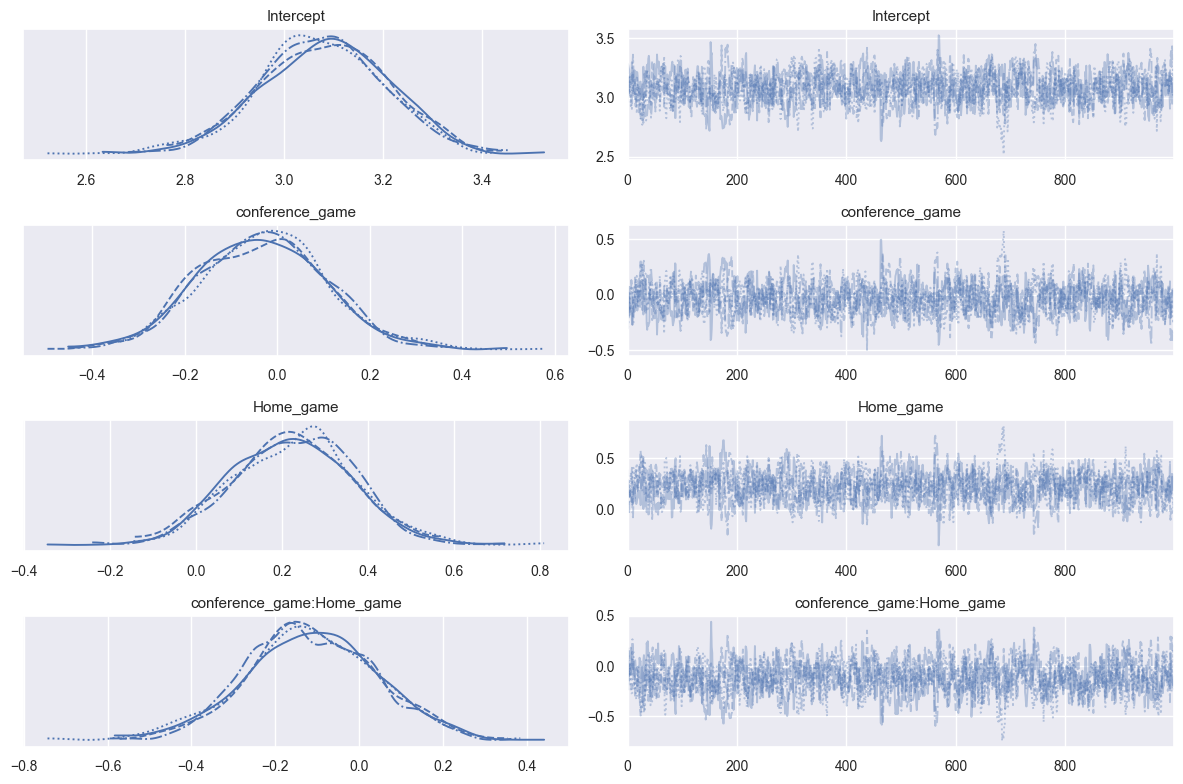

In [10]:
az.plot_trace(points)
plt.tight_layout()

Okay, back in cartesian space, what's the average scoring?


In [11]:
az.summary(np.exp(points.posterior["Intercept"]), kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,21.928,2.761,16.786,27.078


Now, given the number of games left (including the bowl), these being conference games, and some of them being at home, what is the chance of Brian getting to stay?

First, he's got to score how much to stay?


In [12]:
points_to_stay = 325
games_left = sum(games["completed"] == False) + 1
home_games_left = home_games_left = sum(
    games[lambda x: ~x.completed].home_team == "Iowa"
)
points_scored_in_2023 = games.loc[games.season == 2023, "Iowa_points"].sum()
points_per_game_to_stay = (points_to_stay - points_scored_in_2023) / games_left
print(f"Score {points_per_game_to_stay} to stay")

Score 29.833333333333332 to stay


In [13]:
p = points.posterior

posterior_2023_points = np.exp(
    (
        p["Intercept"]
        + p["conference_game"]
        + (home_games_left / games_left) * p["Home_game"]
    ).data.ravel()
)
# plt.hist(posterior_2023_points, bins=np.arange(15, 35), cumulative=True, align="left")
# np.percentile(posterior_2023_points, 90)
print(
    "Chance of Brian staying:",
    np.mean(posterior_2023_points >= points_per_game_to_stay),
)

Chance of Brian staying: 0.0045


That's not good. Let's make a plot to look at the distribution


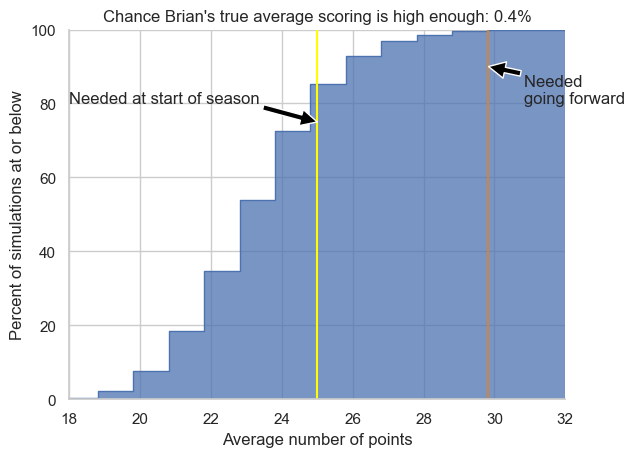

In [14]:
with sns.axes_style("whitegrid"):
    g = sns.histplot(
        posterior_2023_points,
        discrete=True,
        element="step",
        stat="percent",
        cumulative=True,
        fill=True,
    )
    g.set(
        xlim=(18, 32),
        ylim=(0, 100),
        ylabel="Percent of simulations at or below",
        xlabel="Average number of points",
        title=f"Chance Brian's true average scoring is high enough: {np.mean(posterior_2023_points >= points_per_game_to_stay):.1%}",
    )
    g.vlines(points_per_game_to_stay, 0, 100, color="peru")
    g.vlines(25, 0, 100, color="yellow")
    sns.despine()
    g.annotate(
        "Needed \ngoing forward",
        xy=(points_per_game_to_stay, 90),
        xytext=(points_per_game_to_stay + 1, 80),
        arrowprops=dict(facecolor="black"),
    )
    g.annotate(
        "Needed at start of season",
        xy=(25, 75),
        xytext=(18, 80),
        arrowprops=dict(facecolor="black"),
    )

[(18.0, 34.0),
 Text(0, 0.5, 'Percent of simulations'),
 Text(0.5, 0, 'Average number of points Iowa scores')]

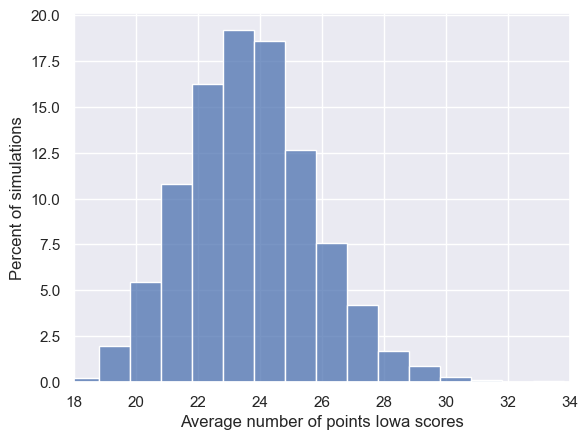

In [15]:
g = sns.histplot(
    posterior_2023_points,
    discrete=True,
    stat="percent",
    fill=True,
)
g.set(
    xlim=(18, 34),
    # ylim=(0, 100),
    ylabel="Percent of simulations",
    xlabel="Average number of points Iowa scores",
)

Okay, that's the average number of points over abour 4,000 virtual Brian Ferentz seasons. But what's the distribution of points that could be scored _this_ season?

Well, a fun thing about the Poisson distribution is the variance is equal to the mean, so we can create the distribution of expected scores from this fact. First, break things into home and away games, then draw from the Poisson distribution given by the posterior for these "simulated" games.


[(0.0, 55.0), Text(0.5, 0, 'Points scored in a game'), Text(0, 0.5, 'Trials')]

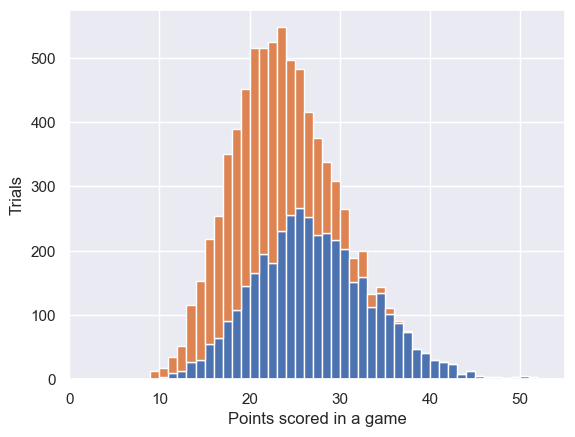

In [16]:
p = points.posterior

posterior_2023_points_home = np.exp(
    (p["Intercept"] + p["conference_game"] + p["Home_game"]).data.ravel()
)
posterior_2023_points_away = np.exp(
    (p["Intercept"] + p["conference_game"]).data.ravel()
)

# And another sampling:
points_distributed_home = np.random.poisson(posterior_2023_points_home)
points_distributed_away = np.random.poisson(posterior_2023_points_away)

fig, ax = plt.subplots()
ax.hist(
    [points_distributed_home, points_distributed_away],
    bins=np.arange(0, 56, 1),
    histtype="barstacked",
)
ax.set(xlim=(0, 55), xlabel="Points scored in a game", ylabel="Trials")

Okay, that distribution looks a little tighter than I would expect, considering the recent PSU game with an offensive output of 0 points. We'll let it stand.


[Text(0.5, 0, 'Total points scored by Iowa in 2023'),
 (0.0, 3.55),
 Text(0.5, 1.0, "Chance we'll see Brian next year: 0.9%")]

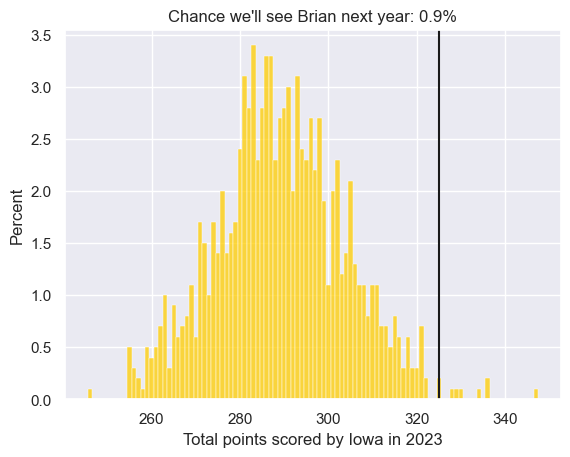

In [17]:
NUM_TRIALS = 1000
points_distributed_total = (
    points_scored_in_2023
    + np.sum(
        np.random.choice(points_distributed_home, size=(NUM_TRIALS, home_games_left)),
        axis=-1,
    )
    + np.sum(
        np.random.choice(
            points_distributed_away, size=(NUM_TRIALS, games_left - home_games_left)
        ),
        axis=-1,
    )
)
likelihood_brian_stays = np.mean(points_distributed_total >= 325)

vline_max = 3.55
g = sns.histplot(
    points_distributed_total, stat="percent", discrete=True, color="#FFCD00"
)
g.vlines(325, 0, vline_max, color="k")
g.set(
    xlabel="Total points scored by Iowa in 2023",
    ylim=(0, vline_max),
    title=f"Chance we'll see Brian next year: {likelihood_brian_stays:.1%}",
)